In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_decision_forests as tfdf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import sys, os, warnings


NotFoundError: d:\CACIC 2024\cacic2024\lib\site-packages\tensorflow_decision_forests\tensorflow\ops\inference\inference.so not found

In [3]:
class SuppressPrints:
    def __enter__(self):
        self._stdout = sys.stdout
        self._stderr = sys.stderr
        self._warnings_showwarning = warnings.showwarning
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')
        warnings.showwarning = self._suppress_warnings

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._stdout
        sys.stderr = self._stderr
        warnings.showwarning = self._warnings_showwarning
    def _suppress_warnings(self, *args, **kwargs):
        pass

# Importo los datos

In [4]:
data = pd.read_csv("Occupancy.csv")
# Elimino el timestamp porque no me interesa usar esta información
data = data.drop(columns=["date"])
data

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.7000,26.2720,585.200000,749.200000,0.004764,1
1,23.7180,26.2900,578.400000,760.400000,0.004773,1
2,23.7300,26.2300,572.666667,769.666667,0.004765,1
3,23.7225,26.1250,493.750000,774.750000,0.004744,1
4,23.7540,26.2000,488.600000,779.000000,0.004767,1
...,...,...,...,...,...,...
20555,20.8150,27.7175,429.750000,1505.250000,0.004213,1
20556,20.8650,27.7450,423.500000,1514.500000,0.004230,1
20557,20.8900,27.7450,423.500000,1521.500000,0.004237,1
20558,20.8900,28.0225,418.750000,1632.000000,0.004279,1


Divido los datos en X e y y los divido en entrenamiento, validación y testeo

In [5]:

# Dividir los datos en características (X) y etiquetas (y)
X = data.drop(columns=["Occupancy"])
y = data["Occupancy"]

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Imprimir las formas de los conjuntos de datos resultantes
print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

NameError: name 'train_test_split' is not defined

# Exploro los datos de entrenamiento

In [ ]:
y_train == 0

17053    True
537      True
12767    True
3005     True
6759     True
         ... 
12668    True
15863    True
9929     True
8769     True
10015    True
Name: Occupancy, Length: 12336, dtype: bool

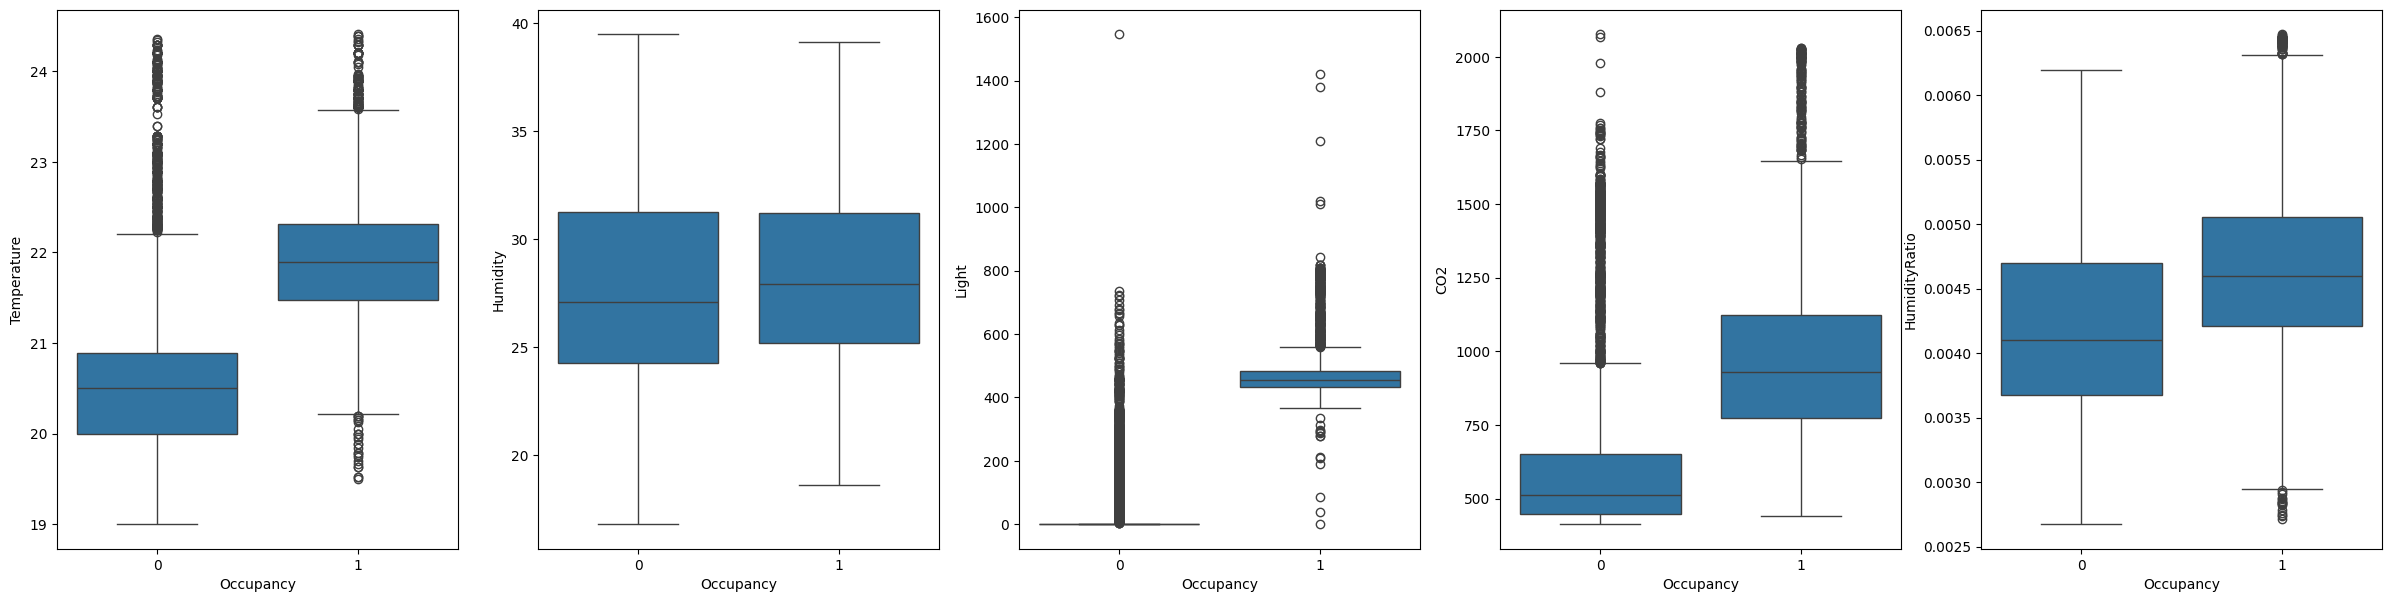

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Create boxplots for each column of X, discriminating by the variable y
fig, axs = plt.subplots(1, 5, figsize=(30, 7))
for (column,ax) in zip(X_train.columns,axs):
    plt.figure()
    sns.boxplot(x=y_train, y=X_train[column], ax=ax)
    # ax.set_xlabel("Occupancy")
    # ax.set_ylabel(column)

plt.show()

De cada variable se observa:
* Temperatura: Parece que está más calido en los momentos en los que hay gente.
* La humedad no muestra grandes diferencias
* La luz tiene distribuciones completamente distintas en ambos casos. Hay mucha más gente en los momentos que hay luz.
* El CO2 también tiene una aparente correlación positiva con la presencia de personas.
* El ratio de humedad tampoco muestra diferencias tna grandes, aunque más notorias que en el nivel absoluto de humedad.

El problema que puede haber es que varios de estos factores en vez de ser consecuencia y algo que permita detectar si hay personas, sean en realidad una causa de que la gente asista o una consecuencia de una causa de que la gente asista, por ejemplo de la hora (hay más calor y luz de día que de noche).

# Aplicamos modelos predictivos y los comparamos

In [ ]:
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices())

2.14.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2024-07-18 11:01:56.265785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 11:01:56.298493: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
import datetime 
# Define the logistic regression model
class LogisticRegression(tf.keras.Model):
    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(num_features,))
        
    def call(self, inputs):
        return self.dense(inputs)

def Paso(epocas):

    # Create an instance of the logistic regression model
    num_features = X_train.shape[1]
    model = LogisticRegression(num_features)

    # Define the loss function and optimizer
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    # Train the model
    # batch_size = [32, 64, 128, 256, 512, len(X_train)]
    # epochs = [3, 3, 10, 10, 10, 100]
    history = {} #"history":{}}
    #model.fit(X_train, y_train, batch_size=batch_size[0], epochs=epochs[0], validation_data=(X_val, y_val))
    
    for b_s, ep in epocas:
        if b_s <= 0:
            b_s = len(X_train)
        history_2 = model.fit(X_train, y_train, batch_size=b_s, epochs=ep, validation_data=(X_val, y_val))
        for key in history_2.history.keys():
            history[key] = history.get(key,[]) + history_2.history[key]
                
    # Evaluate the model on the test set
    y_pred = model.predict(X_val)
    y_pred = (y_pred > 0.5).astype(int).reshape(-1)
    accuracy = accuracy_score(y_val, y_pred)
    print("Accuracy : {}/{}".format(sum(y_pred==y_val), len(y_val)))
    print("Accuracy:{:.4f}".format(accuracy))
    


In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score

# Define the logistic regression model
class LogisticRegression(tf.keras.Model):
    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(num_features,))
        
    def call(self, inputs):
        return self.dense(inputs)

# Create an instance of the logistic regression model
num_features = X_train.shape[1]
model = LogisticRegression(num_features)

# Define the loss function and optimizer
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Train the model
batch_size = [32, 64, 128, 256, 512, len(X_train)]
epochs = [10, 10, 10, 10, 10, 100]
history = model.fit(X_train, y_train, batch_size=batch_size[0], epochs=epochs[0], validation_data=(X_val, y_val))

for b_s, ep in zip(batch_size[1:], epochs[1:]):
    history_2 = model.fit(X_train, y_train, batch_size=b_s, epochs=ep, validation_data=(X_val, y_val))
    for key in history.history.keys():
        history.history[key] += history_2.history[key]
        
# Evaluate the model on the test set
y_pred = model.predict(X_val)
y_pred = (y_val > 0.5).astype(int)
accuracy = accuracy_score(y_val, y_pred)

Epoch 1/10
386/386 [==============================] - 6s 14ms/step - loss: 64.8438 - accuracy: 0.8999 - val_loss: 24.4895 - val_accuracy: 0.9392
Epoch 2/10
386/386 [==============================] - 5s 13ms/step - loss: 55.5940 - accuracy: 0.9090 - val_loss: 59.6799 - val_accuracy: 0.9210
Epoch 3/10
386/386 [==============================] - 5s 13ms/step - loss: 52.7557 - accuracy: 0.9173 - val_loss: 18.1872 - val_accuracy: 0.9572
Epoch 4/10
386/386 [==============================] - 5s 14ms/step - loss: 49.4339 - accuracy: 0.9155 - val_loss: 40.9943 - val_accuracy: 0.8969
Epoch 5/10
386/386 [==============================] - 5s 13ms/step - loss: 45.3062 - accuracy: 0.9215 - val_loss: 21.1607 - val_accuracy: 0.9599
Epoch 6/10
386/386 [==============================] - 5s 13ms/step - loss: 39.9002 - accuracy: 0.9256 - val_loss: 31.1413 - val_accuracy: 0.8945
Epoch 7/10
386/386 [==============================] - 5s 13ms/step - loss: 38.1052 - accuracy: 0.9266 - val_loss: 14.1083 - val_ac

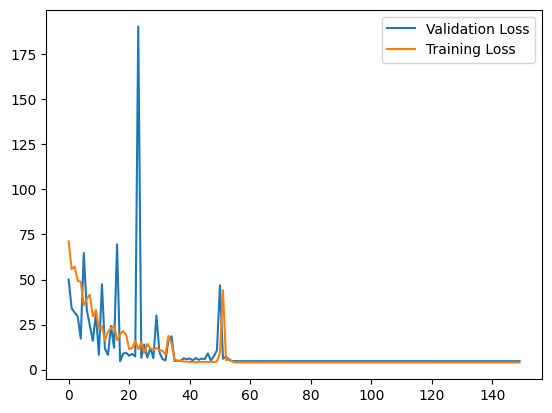

In [ ]:
history_2 = history.history
plt.plot(
    list(zip(history_2["val_loss"],history_2["loss"])),
    label = ["Validation Loss", "Training Loss"]
)
plt.legend()
plt.show()

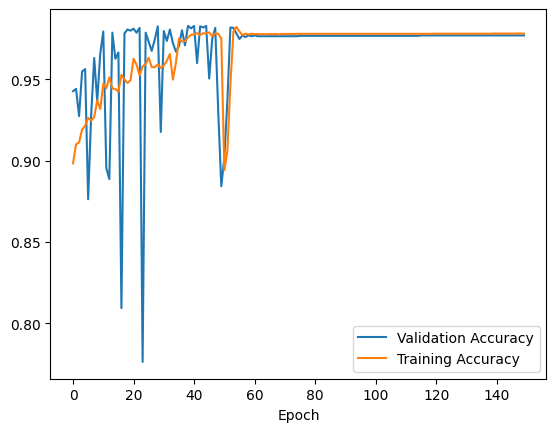

In [ ]:
plt.plot(
    list(zip(history_2["val_accuracy"],history_2["accuracy"])),
    label = ["Validation Accuracy", "Training Accuracy"]
)
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
pd.concat([X_train, y_train], axis=1)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
17053,20.290000,30.600,0.00,721.333333,0.004505,0
537,20.700000,22.330,0.00,454.600000,0.003366,0
12767,21.000000,26.495,0.00,568.500000,0.004072,0
3005,21.200000,25.390,0.00,467.000000,0.003950,0
6759,22.600000,17.175,163.25,443.750000,0.002905,0
...,...,...,...,...,...,...
12668,21.100000,27.090,0.00,567.000000,0.004190,0
15863,20.066667,33.790,0.00,551.000000,0.004910,0
9929,21.200000,36.200,0.00,1341.000000,0.005647,0
8769,19.500000,27.290,0.00,450.000000,0.003821,0


In [ ]:
# Create the Random Forest model
random_forest = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)

# Train the model with the training data

rf_data = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_train, y_train], axis=1), label="Occupancy")

random_forest.fit(rf_data)

# Make predictions on the training data
y_pred_train = random_forest.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_train))
# Crear el modelo de Random Forest
print("Random Forest model created, Train Accuracy: {:.5f}".format(accuracy_score(y_train, y_pred_train>0.5)))

# Make predictions on the val data

y_pred_val = random_forest.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_val))
print("Random Forest model created, Val Accuracy: {:.5f}".format(accuracy_score(y_val, y_pred_val>0.5)))

Use /tmp/tmpooev62c_ as temporary training directory
Reading training dataset...


Training dataset read in 0:00:00.278375. Found 12336 examples.
Training model...
Model trained in 0:00:00.695194
Compiling model...


[INFO 24-07-18 00:29:15.8045 -03 kernel.cc:1233] Loading model from path /tmp/tmpooev62c_/model/ with prefix 1146b964bf834f35
[INFO 24-07-18 00:29:15.8664 -03 decision_forest.cc:734] Model loaded with 300 root(s), 39520 node(s), and 5 input feature(s).
[INFO 24-07-18 00:29:15.8665 -03 abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-07-18 00:29:15.8665 -03 kernel.cc:1061] Use fast generic engine


Model compiled.


13/13 [==============================] - 0s 10ms/step
Random Forest model created, Train Accuracy: 0.99660
5/5 [==============================] - 0s 8ms/step
Random Forest model created, Val Accuracy: 0.99003


In [ ]:
def Informar(mascara):
    indices = np.array([(mascara&(2**i)!=0) for i in range(len(X_train.columns))])
    
    X_train_mascara = X_train.iloc[:,indices]
    X_val_mascara = X_val.iloc[:,indices]
    random_forest = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
    rf_data = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_train_mascara, y_train], axis=1), label="Occupancy")
    random_forest.fit(rf_data)
    y_pred_val = random_forest.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_val_mascara))
    
    rf_accuracy = accuracy_score(y_val, y_pred_val>0.5)

    logistic = LogisticRegression(len(X_train_mascara.columns))
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

    logistic.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    epochs = [10, 10, 200]
    batch_size = [32, 128, len(X_train_mascara)]
    learning_rate = [0.1, 0.01, 0.001]

    for (ep, bs) in zip(epochs, batch_size):
        logistic.fit(X_train_mascara, y_train, epochs=ep, batch_size=bs)
        
    y_pred_val = logistic.predict(X_val_mascara)
    logistic_accuracy = accuracy_score(y_val, y_pred_val>0.5)

    return (X_train_mascara.columns, rf_accuracy, logistic_accuracy) 

In [ ]:
with SuppressPrints():
    results = [Informar(i) for i in range(1, 2**len(X_train.columns))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7698 - loss: 404.0097
Epoch 87/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8357 - loss: 95.7908
Epoch 88/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7536 - loss: 120.1403
Epoch 89/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5355 - loss: 273.3549
Epoch 90/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7698 - loss: 403.7321
Epoch 91/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8356 - loss: 95.9226
Epoch 92/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7536 - loss: 120.0695
Epoch 93/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5358 - loss: 273.1873
Epoch 94/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7698 - loss: 403.4376
Epoch 95/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8356 - loss: 96.0617
Epoch 96/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7536 - loss: 120.0236
Epoch 97/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accura

[INFO 24-07-18 00:53:34.2731 -03 kernel.cc:1233] Loading model from path /tmp/tmpfh74rmn0/model/ with prefix 235ba64c734147ff


Model trained in 0:00:01.300908
Compiling model...
Model compiled.


[INFO 24-07-18 00:53:34.4780 -03 decision_forest.cc:734] Model loaded with 300 root(s), 126182 node(s), and 4 input feature(s).
[INFO 24-07-18 00:53:34.4781 -03 abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-07-18 00:53:34.4781 -03 kernel.cc:1061] Use fast generic engine


5/5 [==============================] - 0s 21ms/step
Epoch 1/10


/home/lautaro/anaconda3/envs/data_11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5878 - loss: 564.6641
Epoch 2/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6124 - loss: 487.4253
Epoch 3/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6379 - loss: 385.1705
Epoch 4/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6721 - loss: 332.6766
Epoch 5/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6791 - loss: 316.6121
Epoch 6/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6804 - loss: 308.6660
Epoch 7/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7012 - loss: 277.3584
Epoch 8/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7253 - loss: 245.4161
Epoch 9/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7238 - loss: 246.0861
Epoch 10/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7200 - loss: 268.2544
Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7731 - loss: 165.4716
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[INFO 24-07-18 00:53:54.3452 -03 kernel.cc:1233] Loading model from path /tmp/tmp7ohh0mp1/model/ with prefix 28c2a2e1cf094bca
[INFO 24-07-18 00:53:54.4180 -03 decision_forest.cc:734] Model loaded with 300 root(s), 41108 node(s), and 3 input feature(s).
[INFO 24-07-18 00:53:54.4180 -03 abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-07-18 00:53:54.4181 -03 kernel.cc:1061] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 8ms/step
Epoch 1/10


/home/lautaro/anaconda3/envs/data_11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8691 - loss: 107.3320
Epoch 2/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9044 - loss: 60.7654
Epoch 3/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8990 - loss: 73.1543
Epoch 4/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9025 - loss: 67.7509
Epoch 5/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8975 - loss: 70.7631
Epoch 6/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8945 - loss: 67.2994
Epoch 7/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8986 - loss: 68.3767
Epoch 8/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9046 - loss: 65.5246
Epoch 9/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8992 - loss: 65.1582
Epoch 10/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9100 - loss: 55.8547
Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9187 - loss: 47.0600
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - ac

[INFO 24-07-18 00:54:14.4571 -03 kernel.cc:1233] Loading model from path /tmp/tmp8eb0ttrd/model/ with prefix 2f2de60f82bc44c1
[INFO 24-07-18 00:54:14.5185 -03 decision_forest.cc:734] Model loaded with 300 root(s), 41310 node(s), and 4 input feature(s).
[INFO 24-07-18 00:54:14.5185 -03 abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-07-18 00:54:14.5185 -03 kernel.cc:1061] Use fast generic engine


5/5 [==============================] - 0s 10ms/step
Epoch 1/10


/home/lautaro/anaconda3/envs/data_11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8720 - loss: 113.5402
Epoch 2/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8948 - loss: 72.0664
Epoch 3/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9110 - loss: 57.6888
Epoch 4/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9110 - loss: 53.3700
Epoch 5/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9183 - loss: 52.6727
Epoch 6/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9188 - loss: 50.9510
Epoch 7/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9103 - loss: 48.5153
Epoch 8/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9255 - loss: 43.1077
Epoch 9/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9165 - loss: 52.0901
Epoch 10/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9228 - loss: 49.4205
Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9503 - loss: 23.8781
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - ac

[INFO 24-07-18 00:54:35.8044 -03 kernel.cc:1233] Loading model from path /tmp/tmpqu829qd4/model/ with prefix 5917177d6273421a
[INFO 24-07-18 00:54:35.8810 -03 decision_forest.cc:734] Model loaded with 300 root(s), 41106 node(s), and 4 input feature(s).
[INFO 24-07-18 00:54:35.8811 -03 abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-07-18 00:54:35.8811 -03 kernel.cc:1061] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 8ms/step
Epoch 1/10


/home/lautaro/anaconda3/envs/data_11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8697 - loss: 103.9601
Epoch 2/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9122 - loss: 56.5511
Epoch 3/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9031 - loss: 60.5809
Epoch 4/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9050 - loss: 55.4205
Epoch 5/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9108 - loss: 57.0202
Epoch 6/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9121 - loss: 50.6584
Epoch 7/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9154 - loss: 45.9180
Epoch 8/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9252 - loss: 41.3942
Epoch 9/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9156 - loss: 47.4836
Epoch 10/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9142 - loss: 51.0454
Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9444 - loss: 26.0365
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - ac

[INFO 24-07-18 00:54:55.8575 -03 kernel.cc:1233] Loading model from path /tmp/tmph1nkpenn/model/ with prefix 2d35ad0f81d94993
[INFO 24-07-18 00:54:55.9130 -03 decision_forest.cc:734] Model loaded with 300 root(s), 39520 node(s), and 5 input feature(s).
[INFO 24-07-18 00:54:55.9130 -03 abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-07-18 00:54:55.9130 -03 kernel.cc:1061] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 9ms/step
Epoch 1/10


/home/lautaro/anaconda3/envs/data_11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8762 - loss: 80.5805
Epoch 2/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9113 - loss: 55.8874
Epoch 3/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9131 - loss: 52.0505
Epoch 4/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9099 - loss: 53.0576
Epoch 5/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9153 - loss: 47.5700
Epoch 6/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9263 - loss: 38.2912
Epoch 7/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9198 - loss: 42.0649
Epoch 8/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9289 - loss: 31.9029
Epoch 9/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9419 - loss: 30.5752
Epoch 10/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9363 - loss: 32.6133
Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9565 - loss: 13.0811
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc

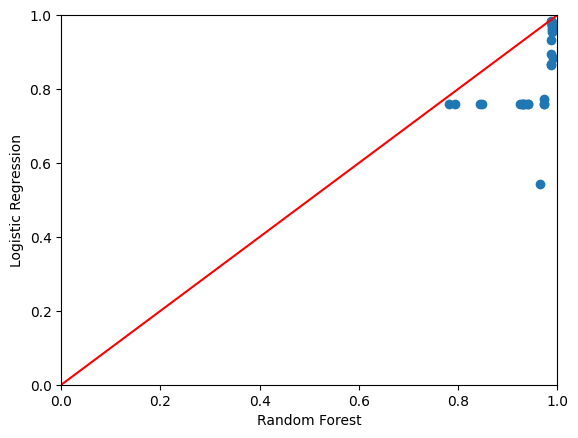

In [ ]:
rf_results = [r[1] for r in results]
lr_results = [r[2] for r in results]
plt.scatter(rf_results, lr_results)
plt.plot(np.linspace(0,1), np.linspace(0,1), 'r')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("Random Forest")
plt.ylabel("Logistic Regression")
plt.show()

In [ ]:
print(sum(np.array(rf_results)>np.array(lr_results)))

31


Cómo se ve, el random forest domina absolutamente a la regresión líneal simple. Para todo subconjunto de las caracteristicas el random forest tiene una mejor performance.

# Incorporar errores

In [ ]:
def Informar_con_error(mascara, alfa = 0):
    indices = np.array([(mascara&(2**i)!=0) for i in range(len(X_train.columns))])
    
    X_train_mascara = X_train
    
    X_val_mascara = X_val.copy()
    
    for i in range(len(X_train.columns)):
        if indices[i]:
            X_val_mascara.iloc[:,i] = X_val_mascara.iloc[:,i]*(1-alfa) + alfa*np.random.normal(
                np.mean(X_val_mascara.iloc[:,i]),
                np.std(X_val_mascara.iloc[:,i]), 
                len(X_val_mascara))
    
    random_forest = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
    rf_data = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_train_mascara, y_train], axis=1), label="Occupancy")
    random_forest.fit(rf_data)
    y_pred_val = random_forest.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_val_mascara))
    
    rf_accuracy = accuracy_score(y_val, y_pred_val>0.5)

    logistic = LogisticRegression(len(X_train_mascara.columns))
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

    logistic.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    epochs = [10, 10, 200]
    batch_size = [32, 128, len(X_train_mascara)]
    learning_rate = [0.1, 0.01, 0.001]

    for (ep, bs) in zip(epochs, batch_size):
        logistic.fit(X_train_mascara, y_train, epochs=ep, batch_size=bs)
        
    y_pred_val = logistic.predict(X_val_mascara)
    logistic_accuracy = accuracy_score(y_val, y_pred_val>0.5)

    return (X_train_mascara.columns, rf_accuracy, logistic_accuracy) 

In [ ]:
Informar_con_error(0,0)

Use /tmp/tmpmhmjtge8 as temporary training directory


Reading training dataset...
Training dataset read in 0:00:00.297459. Found 12336 examples.
Training model...
Model trained in 0:00:00.607521
Compiling model...
Model compiled.


[INFO 24-07-18 11:18:49.5485 -03 kernel.cc:1233] Loading model from path /tmp/tmpmhmjtge8/model/ with prefix 77d1db2b14414723
[INFO 24-07-18 11:18:49.6070 -03 decision_forest.cc:660] Model loaded with 300 root(s), 39520 node(s), and 5 input feature(s).
[INFO 24-07-18 11:18:49.6070 -03 abstract_model.cc:1343] Engine "RandomForestOptPred" built
[INFO 24-07-18 11:18:49.6071 -03 kernel.cc:1061] Use fast generic engine


5/5 [==============================] - 0s 9ms/step
Epoch 1/10
386/386 [==============================] - 2s 3ms/step - loss: 67.4277 - accuracy: 0.9000
Epoch 2/10
386/386 [==============================] - 1s 3ms/step - loss: 60.7777 - accuracy: 0.9079
Epoch 3/10
386/386 [==============================] - 1s 3ms/step - loss: 47.8519 - accuracy: 0.9146
Epoch 4/10
386/386 [==============================] - 1s 3ms/step - loss: 49.1043 - accuracy: 0.9157
Epoch 5/10
386/386 [==============================] - 1s 3ms/step - loss: 40.7913 - accuracy: 0.9217
Epoch 6/10
386/386 [==============================] - 1s 3ms/step - loss: 38.6403 - accuracy: 0.9273
Epoch 7/10
386/386 [==============================] - 1s 3ms/step - loss: 34.9664 - accuracy: 0.9290
Epoch 8/10
386/386 [==============================] - 1s 3ms/step - loss: 38.5552 - accuracy: 0.9284
Epoch 9/10
386/386 [==============================] - 1s 3ms/step - loss: 32.4319 - accuracy: 0.9322
Epoch 10/10
386/386 [===================

(Index(['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'], dtype='object'),
 0.9900291828793775,
 0.9783560311284046)

In [ ]:
with SuppressPrints():
    results = [Informar_con_error(2**i, 0.25) for i in range(len(X_train.columns))]
print(results)

In [ ]:
print(results)
print("x")

In [ ]:
alfas = [0.25, 0.5, 0.75, 1]
results = [[Informar_con_error(i, alfa) for i in range(1, 2**len(X_train.columns))] for alfa in alfas]

Use /tmp/tmpgz2oyfqi as temporary training directory


Reading training dataset...
Training dataset read in 0:00:03.968300. Found 12336 examples.
Training model...
Model trained in 0:00:00.720743
Compiling model...


[INFO 24-07-18 11:10:05.1924 -03 kernel.cc:1233] Loading model from path /tmp/tmpgz2oyfqi/model/ with prefix 15e35dfa87c24388
[INFO 24-07-18 11:10:05.2659 -03 decision_forest.cc:660] Model loaded with 300 root(s), 39520 node(s), and 5 input feature(s).
[INFO 24-07-18 11:10:05.2661 -03 abstract_model.cc:1343] Engine "RandomForestOptPred" built
[INFO 24-07-18 11:10:05.2662 -03 kernel.cc:1061] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 11ms/step
Epoch 1/10
386/386 [==============================] - 2s 3ms/step - loss: 74.1974 - accuracy: 0.8959
Epoch 2/10
386/386 [==============================] - 1s 3ms/step - loss: 60.3743 - accuracy: 0.9056
Epoch 3/10
386/386 [==============================] - 1s 3ms/step - loss: 47.6322 - accuracy: 0.9188
Epoch 4/10
386/386 [==============================] - 1s 4ms/step - loss: 48.1822 - accuracy: 0.9179
Epoch 5/10
386/386 [==============================] - 1s 3ms/step - loss: 42.4799 - accuracy: 0.9285
Epoch 6/10
386/386 [==============================] - 1s 3ms/step - loss: 48.4776 - accuracy: 0.9219
Epoch 7/10
386/386 [==============================] - 1s 3ms/step - loss: 38.4768 - accuracy: 0.9274
Epoch 8/10
386/386 [==============================] - 1s 3ms/step - loss: 37.3279 - accuracy: 0.9286
Epoch 9/10
386/386 [==============================] - 1s 3ms/step - loss: 32.0049 - accuracy: 0.9337
Epoch 10/10
386/386 [==

[INFO 24-07-18 11:10:27.0059 -03 kernel.cc:1233] Loading model from path /tmp/tmpxtsuvqoj/model/ with prefix 83a0bf47d9ba447d
[INFO 24-07-18 11:10:27.0730 -03 decision_forest.cc:660] Model loaded with 300 root(s), 39520 node(s), and 5 input feature(s).
[INFO 24-07-18 11:10:27.0731 -03 abstract_model.cc:1343] Engine "RandomForestOptPred" built
[INFO 24-07-18 11:10:27.0731 -03 kernel.cc:1061] Use fast generic engine


Model compiled.
5/5 [==============================] - 0s 9ms/step
Epoch 1/10
386/386 [==============================] - 2s 3ms/step - loss: 69.2607 - accuracy: 0.9013
Epoch 2/10
386/386 [==============================] - 1s 3ms/step - loss: 55.3034 - accuracy: 0.9089
Epoch 3/10
386/386 [==============================] - 1s 3ms/step - loss: 53.4763 - accuracy: 0.9115
Epoch 4/10
386/386 [==============================] - 1s 3ms/step - loss: 50.4948 - accuracy: 0.9173
Epoch 5/10
386/386 [==============================] - 1s 3ms/step - loss: 39.3854 - accuracy: 0.9229
Epoch 6/10
386/386 [==============================] - 1s 3ms/step - loss: 40.3831 - accuracy: 0.9221
Epoch 7/10
386/386 [==============================] - 1s 3ms/step - loss: 33.0720 - accuracy: 0.9338
Epoch 8/10
386/386 [==============================] - 1s 3ms/step - loss: 36.1864 - accuracy: 0.9292
Epoch 9/10
386/386 [==============================] - 1s 3ms/step - loss: 33.7215 - accuracy: 0.9329
Epoch 10/10
386/386 [===

[INFO 24-07-18 11:10:47.6575 -03 kernel.cc:1233] Loading model from path /tmp/tmp3mzqrski/model/ with prefix af85f876e47b483c
[INFO 24-07-18 11:10:47.7214 -03 decision_forest.cc:660] Model loaded with 300 root(s), 39520 node(s), and 5 input feature(s).
[INFO 24-07-18 11:10:47.7214 -03 abstract_model.cc:1343] Engine "RandomForestOptPred" built
[INFO 24-07-18 11:10:47.7215 -03 kernel.cc:1061] Use fast generic engine


5/5 [==============================] - 0s 9ms/step
Epoch 1/10
386/386 [==============================] - 2s 3ms/step - loss: 65.1451 - accuracy: 0.9020
Epoch 2/10
386/386 [==============================] - 1s 3ms/step - loss: 55.5572 - accuracy: 0.9086
Epoch 3/10
386/386 [==============================] - ETA: 0s - loss: 54.9242 - accuracy: 0.9155

KeyboardInterrupt: 